In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("TEMPERATURE SENSOR CALIBRATION - FULL RANGE (23-100°C)")
print("="*80)

TEMPERATURE SENSOR CALIBRATION - FULL RANGE (23-100°C)


In [20]:
# ============================================================================
# CELL 1: Load and Explore Full Dataset
# ============================================================================
print("\n[CELL 1] Loading full dataset...")

df = pd.read_csv('/kaggle/input/sensor3data-hotplate/Copy of ESP32 Data - Sensor3_hotplate.csv')

print(f"Original data shape: {df.shape}")
print(f"\nTemperature range: {df['MAX6675_TEMP_C'].min():.2f}°C to {df['MAX6675_TEMP_C'].max():.2f}°C")
print(f"Resistance range: {df['Custom_Resistance'].min():.2f}Ω to {df['Custom_Resistance'].max():.2f}Ω")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())


[CELL 1] Loading full dataset...
Original data shape: (548, 7)

Temperature range: 23.00°C to 102.50°C
Resistance range: 2991.75Ω to 9715.94Ω

First few rows:
            Timestamp  MAX6675_TEMP_C  Custom_ADC  Custom_Vout  \
0  10/10/2025 0:46:58           23.25        3086        2.487   
1  10/10/2025 0:47:08           23.25        3054        2.461   
2  10/10/2025 0:47:21           23.00        2928        2.360   
3  10/10/2025 0:47:40           23.50        2864        2.308   
4  10/10/2025 0:47:52           24.00        2845        2.293   

   Custom_Resistance  Env_Temp_C  Env_Humidity_%  
0            3269.60       24.51           52.29  
1            3408.64       24.17           53.59  
2            3985.66       23.82           53.77  
3            4298.18       23.35           55.27  
4            4393.67       23.11           55.89  

Last few rows:
              Timestamp  MAX6675_TEMP_C  Custom_ADC  Custom_Vout  \
543  10/10/2025 2:27:27          101.25        2294  

In [21]:
# ============================================================================
# CELL 2: Data Quality Check and Cleaning
# ============================================================================
print("\n[CELL 2] Data quality assessment...")

# Check for missing/invalid values
print("\nChecking for invalid sensor readings...")
invalid_env = (df['Env_Temp_C'] == -999) | (df['Env_Humidity_%'] == -999)
print(f"Found {invalid_env.sum()} rows with invalid environmental sensor readings")

# Check for outliers
temp_range_ok = (df['MAX6675_TEMP_C'] >= 20) & (df['MAX6675_TEMP_C'] <= 110)
resist_range_ok = (df['Custom_Resistance'] > 0) & (df['Custom_Resistance'] < 30000)

print(f"Temperature out of range: {(~temp_range_ok).sum()} rows")
print(f"Resistance out of range: {(~resist_range_ok).sum()} rows")

# Clean data
df_clean = df[temp_range_ok & resist_range_ok].copy()
df_clean = df_clean.reset_index(drop=True)

# Handle invalid environmental readings - forward fill for short gaps
df_clean.loc[df_clean['Env_Temp_C'] == -999, 'Env_Temp_C'] = np.nan
df_clean.loc[df_clean['Env_Humidity_%'] == -999, 'Env_Humidity_%'] = np.nan
df_clean['Env_Temp_C'].fillna(method='ffill', inplace=True)
df_clean['Env_Humidity_%'].fillna(method='ffill', inplace=True)

# Fill any remaining NaN with column median
df_clean['Env_Temp_C'].fillna(df_clean['Env_Temp_C'].median(), inplace=True)
df_clean['Env_Humidity_%'].fillna(df_clean['Env_Humidity_%'].median(), inplace=True)

print(f"\nCleaned data shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows ({100*(len(df)-len(df_clean))/len(df):.1f}%)")


[CELL 2] Data quality assessment...

Checking for invalid sensor readings...
Found 0 rows with invalid environmental sensor readings
Temperature out of range: 0 rows
Resistance out of range: 0 rows

Cleaned data shape: (548, 7)
Removed 0 rows (0.0%)


In [22]:
# ============================================================================
# CELL 3: Apply Light Smoothing
# ============================================================================
print("\n[CELL 3] Applying smoothing...")

# Light 3-point moving average
window = 3
df_clean['T'] = df_clean['MAX6675_TEMP_C'].rolling(window=window, center=True, min_periods=1).mean()
df_clean['R'] = df_clean['Custom_Resistance'].rolling(window=window, center=True, min_periods=1).mean()
df_clean['T_env'] = df_clean['Env_Temp_C']
df_clean['H'] = df_clean['Env_Humidity_%']

print(f"Temperature smoothed: {df_clean['T'].min():.2f}°C to {df_clean['T'].max():.2f}°C")
print(f"Resistance smoothed: {df_clean['R'].min():.2f}Ω to {df_clean['R'].max():.2f}Ω")


[CELL 3] Applying smoothing...
Temperature smoothed: 23.17°C to 102.33°C
Resistance smoothed: 3339.12Ω to 9398.03Ω



[CELL 4] Creating visualizations...


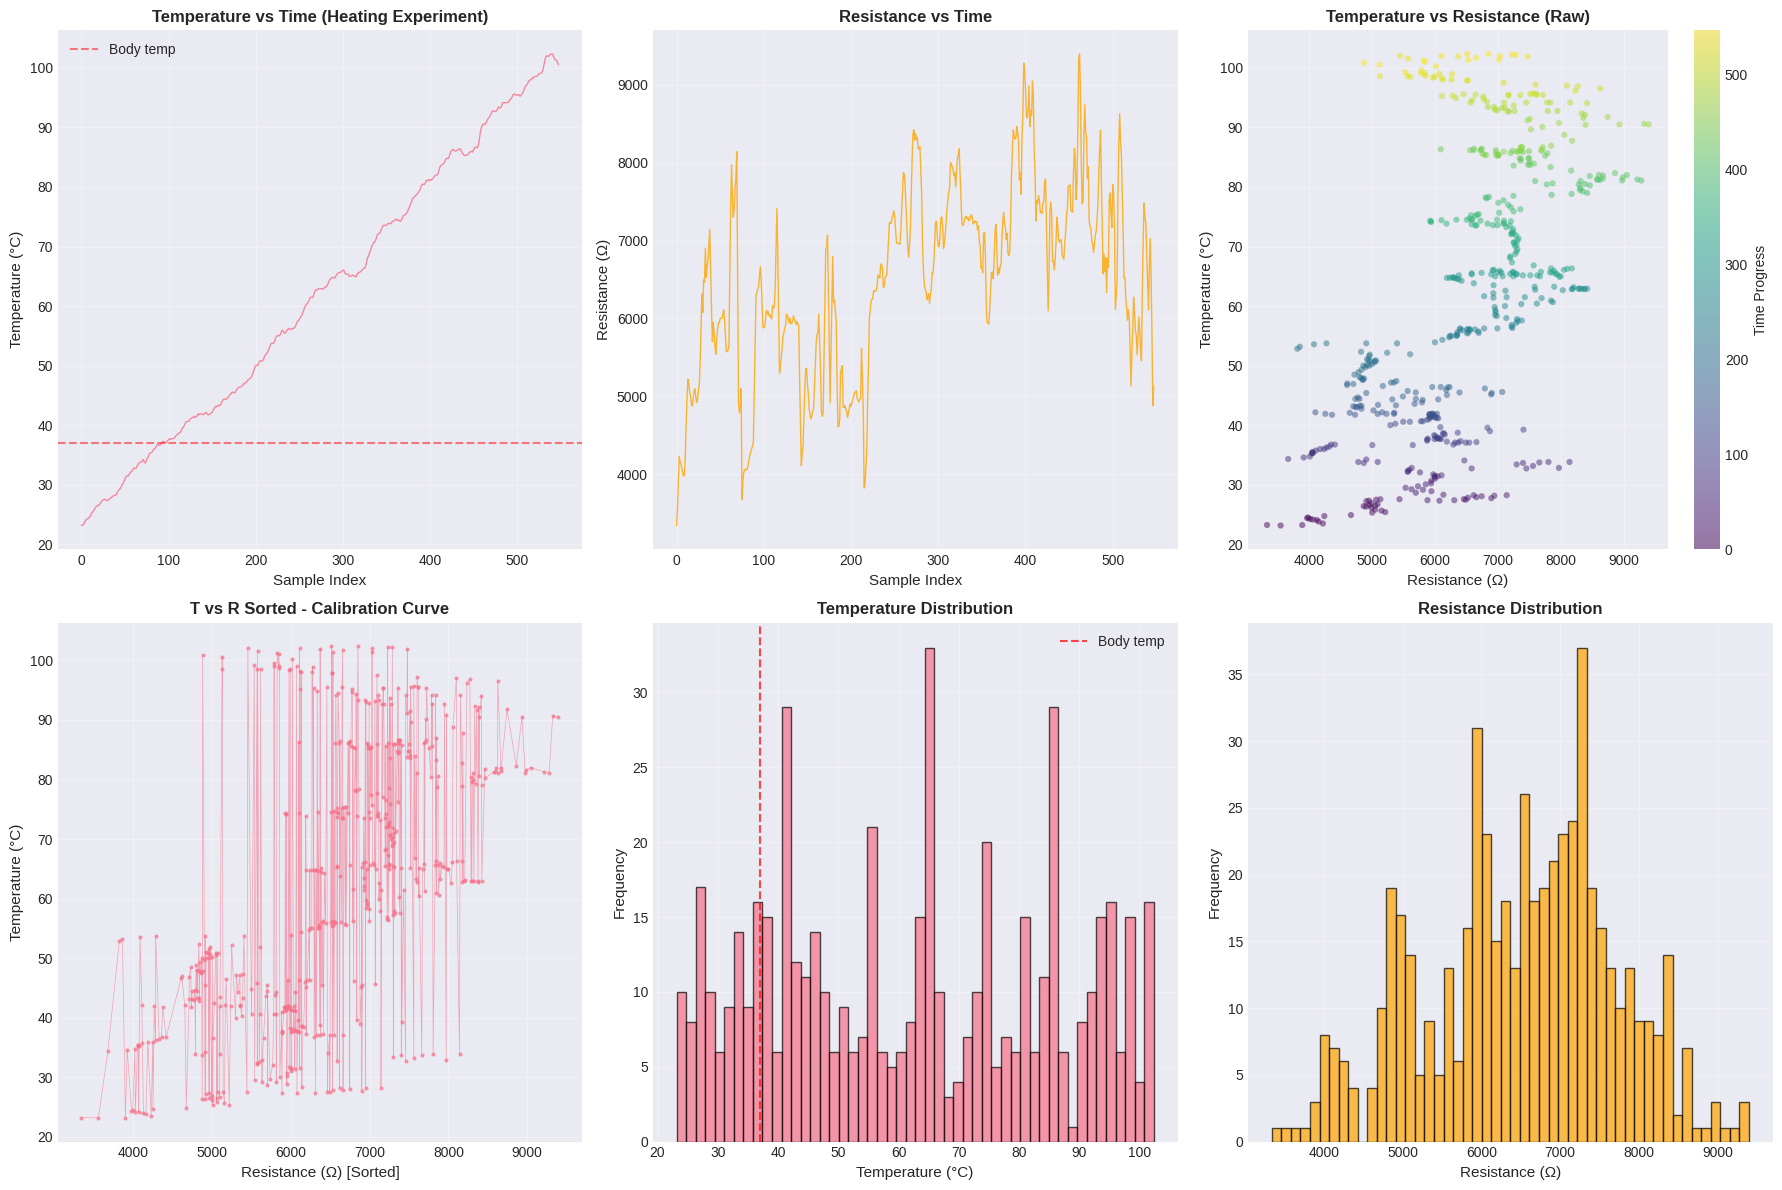

Visualization saved: full_range_data_analysis.png


In [23]:
# ============================================================================
# CELL 4: Comprehensive Visualization
# ============================================================================
print("\n[CELL 4] Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Temperature over time
axes[0, 0].plot(df_clean.index, df_clean['T'], linewidth=1, alpha=0.8)
axes[0, 0].set_xlabel('Sample Index', fontsize=11)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].set_title('Temperature vs Time (Heating Experiment)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=37, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label='Body temp')
axes[0, 0].legend()

# Plot 2: Resistance over time
axes[0, 1].plot(df_clean.index, df_clean['R'], linewidth=1, alpha=0.8, color='orange')
axes[0, 1].set_xlabel('Sample Index', fontsize=11)
axes[0, 1].set_ylabel('Resistance (Ω)', fontsize=11)
axes[0, 1].set_title('Resistance vs Time', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: T vs R scatter (THIS IS THE KEY CALIBRATION CURVE!)
scatter = axes[0, 2].scatter(df_clean['R'], df_clean['T'], 
                             c=df_clean.index, cmap='viridis', 
                             alpha=0.5, s=20, edgecolors='none')
axes[0, 2].set_xlabel('Resistance (Ω)', fontsize=11)
axes[0, 2].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 2].set_title('Temperature vs Resistance (Raw)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 2], label='Time Progress')

# Plot 4: T vs R sorted (should show clear trend)
df_sorted = df_clean.sort_values('R')
axes[1, 0].plot(df_sorted['R'], df_sorted['T'], 'o-', 
                markersize=2, linewidth=0.5, alpha=0.6)
axes[1, 0].set_xlabel('Resistance (Ω) [Sorted]', fontsize=11)
axes[1, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[1, 0].set_title('T vs R Sorted - Calibration Curve', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Temperature distribution
axes[1, 1].hist(df_clean['T'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Temperature (°C)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Temperature Distribution', fontsize=12, fontweight='bold')
axes[1, 1].axvline(x=37, color='r', linestyle='--', alpha=0.7, label='Body temp')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Resistance distribution
axes[1, 2].hist(df_clean['R'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 2].set_xlabel('Resistance (Ω)', fontsize=11)
axes[1, 2].set_ylabel('Frequency', fontsize=11)
axes[1, 2].set_title('Resistance Distribution', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('full_range_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: full_range_data_analysis.png")

In [24]:
# ============================================================================
# CELL 5: Feature Engineering
# ============================================================================
print("\n[CELL 5] Feature engineering...")

# Thermistor-inspired features (PEDOT:PSS behaves similarly to NTC thermistor)
df_clean['R_inv'] = 1.0 / df_clean['R']
df_clean['ln_R'] = np.log(df_clean['R'])
df_clean['ln_R_sq'] = (np.log(df_clean['R'])) ** 2
df_clean['ln_R_cb'] = (np.log(df_clean['R'])) ** 3 

# Additional non-linear features
df_clean['R_sqrt'] = np.sqrt(df_clean['R'])
df_clean['R_sq'] = df_clean['R'] ** 2

# Environmental interaction terms
df_clean['R_T_env'] = df_clean['R'] * df_clean['T_env']
df_clean['R_H'] = df_clean['R'] * df_clean['H']
df_clean['T_env_H'] = df_clean['T_env'] * df_clean['H']

# Log transformations for environmental factors
df_clean['ln_R_T_env'] = df_clean['ln_R'] * df_clean['T_env']
df_clean['ln_R_H'] = df_clean['ln_R'] * df_clean['H']

print("Features created:")
print("  - Thermistor features: R_inv, ln_R, ln_R_sq, ln_R_cb")
print("  - Polynomial features: R_sqrt, R_sq")
print("  - Interaction features: R_T_env, R_H, T_env_H, ln_R_T_env, ln_R_H")


[CELL 5] Feature engineering...
Features created:
  - Thermistor features: R_inv, ln_R, ln_R_sq, ln_R_cb
  - Polynomial features: R_sqrt, R_sq
  - Interaction features: R_T_env, R_H, T_env_H, ln_R_T_env, ln_R_H



[CELL 6] Analyzing feature correlations...


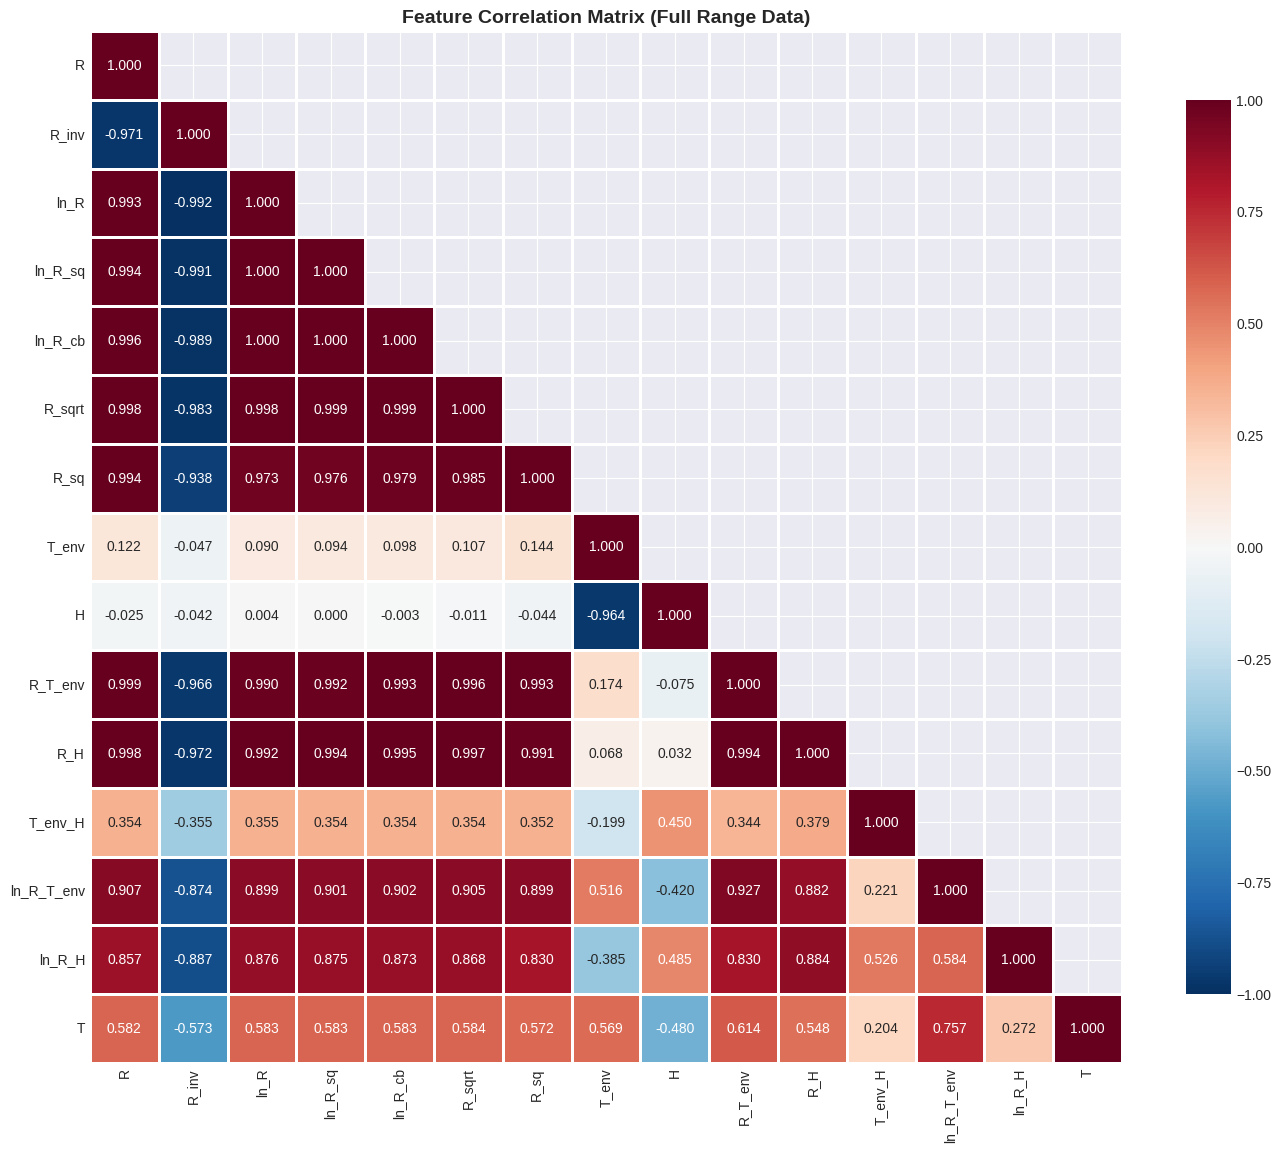


Top 10 correlations with Temperature:
 1. ln_R_T_env     : +0.7573
 2. R_T_env        : +0.6136
 3. R_sqrt         : +0.5836
 4. ln_R_cb        : +0.5834
 5. ln_R_sq        : +0.5831
 6. ln_R           : +0.5827
 7. R              : +0.5820
 8. R_inv          : -0.5732
 9. R_sq           : +0.5721
10. T_env          : +0.5691

 Correlation analysis saved: correlation_matrix_full_range.png


In [25]:
# ============================================================================
# CELL 6: Correlation Analysis
# ============================================================================
print("\n[CELL 6] Analyzing feature correlations...")

feature_cols = ['R', 'R_inv', 'ln_R', 'ln_R_sq', 'ln_R_cb', 'R_sqrt', 'R_sq',
                'T_env', 'H', 'R_T_env', 'R_H', 'T_env_H', 'ln_R_T_env', 'ln_R_H']

corr_matrix = df_clean[feature_cols + ['T']].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=1, fmt='.3f', vmin=-1, vmax=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Full Range Data)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_full_range.png', dpi=300, bbox_inches='tight')
plt.show()

temp_corr = corr_matrix['T'].drop('T').sort_values(key=abs, ascending=False)
print("\nTop 10 correlations with Temperature:")
for i, (feature, corr) in enumerate(temp_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature:15s}: {corr:+.4f}")

print("\n Correlation analysis saved: correlation_matrix_full_range.png")

In [26]:
# ============================================================================
# CELL 7: Define Feature Sets
# ============================================================================
print("\n[CELL 7] Defining feature sets for comparison...")

feature_sets = {
    'Simple': ['R', 'T_env', 'H'],
    
    'Logarithmic': ['ln_R', 'T_env', 'H'],
    
    'Steinhart_Hart': ['R_inv', 'ln_R', 'ln_R_cb', 'T_env', 'H'],
    
    'Comprehensive': ['R', 'R_inv', 'ln_R', 'ln_R_sq', 'ln_R_cb',
                      'T_env', 'H', 'R_T_env', 'ln_R_T_env'],
    
    'Top_Correlations': temp_corr.head(8).index.tolist()
}

for name, features in feature_sets.items():
    print(f"\n{name}:")
    print(f"  Features: {features}")


[CELL 7] Defining feature sets for comparison...

Simple:
  Features: ['R', 'T_env', 'H']

Logarithmic:
  Features: ['ln_R', 'T_env', 'H']

Steinhart_Hart:
  Features: ['R_inv', 'ln_R', 'ln_R_cb', 'T_env', 'H']

Comprehensive:
  Features: ['R', 'R_inv', 'ln_R', 'ln_R_sq', 'ln_R_cb', 'T_env', 'H', 'R_T_env', 'ln_R_T_env']

Top_Correlations:
  Features: ['ln_R_T_env', 'R_T_env', 'R_sqrt', 'ln_R_cb', 'ln_R_sq', 'ln_R', 'R', 'R_inv']


In [27]:
# ============================================================================
# CELL 8: Train and Compare Models
# ============================================================================
print("\n[CELL 8] Training models with different feature sets...")

target = 'T'
y = df_clean[target].values

results = []
trained_models = {}

for fs_name, features in feature_sets.items():
    print(f"\n{'='*80}")
    print(f"Feature Set: {fs_name}")
    print(f"{'='*80}")
    
    X = df_clean[features].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'LinearReg': LinearRegression(),
        'Ridge': Ridge(alpha=10.0),
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=20,
                                              min_samples_split=5, random_state=42, n_jobs=-1),
        'GradientBoost': GradientBoostingRegressor(n_estimators=200, max_depth=7,
                                                   learning_rate=0.05, random_state=42)
    }
    
    print(f"\n{'Model':<15} {'Train MAE':<12} {'Test MAE':<12} {'Test RMSE':<12} {'Test R²':<10}")
    print("-" * 70)
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        
        print(f"{model_name:<15} {train_mae:<12.3f} {test_mae:<12.3f} {test_rmse:<12.3f} {test_r2:<10.4f}")
        
        results.append({
            'FeatureSet': fs_name,
            'Model': model_name,
            'Train_MAE': train_mae,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Test_R2': test_r2,
            'N_Features': len(features)
        })
        
        # Store best models
        key = f"{fs_name}_{model_name}"
        trained_models[key] = {
            'model': model,
            'scaler': scaler,
            'features': features,
            'test_r2': test_r2
        }


[CELL 8] Training models with different feature sets...

Feature Set: Simple

Model           Train MAE    Test MAE     Test RMSE    Test R²   
----------------------------------------------------------------------
LinearReg       9.480        11.507       19.581       0.3832    
Ridge           9.517        11.677       19.752       0.3724    
RandomForest    1.909        3.737        5.461        0.9520    
GradientBoost   0.255        3.083        5.231        0.9560    

Feature Set: Logarithmic

Model           Train MAE    Test MAE     Test RMSE    Test R²   
----------------------------------------------------------------------
LinearReg       9.375        11.310       18.793       0.4318    
Ridge           9.419        11.527       18.970       0.4211    
RandomForest    1.908        3.760        5.545        0.9505    
GradientBoost   0.255        3.091        5.235        0.9559    

Feature Set: Steinhart_Hart

Model           Train MAE    Test MAE     Test RMSE    Test R²

In [28]:
# ============================================================================
# CELL 9: Results Summary
# ============================================================================
print("\n[CELL 9] Results summary...")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_R2', ascending=False)

print("\n" + "="*80)
print("COMPLETE RESULTS (Sorted by Test R²)")
print("="*80)
print(results_df.to_string(index=False))

best_idx = results_df.index[0]
best = results_df.loc[best_idx]

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Feature Set: {best['FeatureSet']}")
print(f"Model Type: {best['Model']}")
print(f"Number of Features: {best['N_Features']}")
print(f"Training MAE: {best['Train_MAE']:.3f}°C")
print(f"Test MAE: {best['Test_MAE']:.3f}°C")
print(f"Test RMSE: {best['Test_RMSE']:.3f}°C")
print(f"Test R²: {best['Test_R2']:.4f}")
print("="*80)


[CELL 9] Results summary...

COMPLETE RESULTS (Sorted by Test R²)
      FeatureSet         Model  Train_MAE  Test_MAE  Test_RMSE  Test_R2  N_Features
  Steinhart_Hart GradientBoost   0.254812  3.092987   5.223739 0.956104           5
          Simple GradientBoost   0.254812  3.083121   5.231037 0.955981           3
     Logarithmic GradientBoost   0.254812  3.091471   5.234562 0.955921           3
          Simple  RandomForest   1.908723  3.737091   5.460511 0.952034           3
  Steinhart_Hart  RandomForest   1.901603  3.715457   5.505571 0.951239           5
     Logarithmic  RandomForest   1.908279  3.759801   5.545370 0.950532           3
   Comprehensive GradientBoost   0.204299  3.780428   6.406555 0.933974           9
   Comprehensive  RandomForest   2.096857  4.367575   6.779741 0.926058           9
Top_Correlations GradientBoost   0.701922  5.436097   7.806228 0.901972           8
Top_Correlations  RandomForest   3.149087  6.509396   8.883027 0.873063           8
Top_Corre

In [29]:
# ============================================================================
# CELL 10: Train Final Production Model
# ============================================================================
print("\n[CELL 10] Training final production model...")

best_key = f"{best['FeatureSet']}_{best['Model']}"
best_model_info = trained_models[best_key]

final_features = best_model_info['features']
final_scaler = best_model_info['scaler']
final_model = best_model_info['model']

print(f"\nFinal Model Configuration:")
print(f"  Features: {final_features}")
print(f"  Model: {best['Model']}")

X_full = df_clean[final_features].values
X_full_scaled = final_scaler.transform(X_full)
y_full_pred = final_model.predict(X_full_scaled)

df_clean['T_predicted'] = y_full_pred
df_clean['T_error'] = df_clean['T'] - df_clean['T_predicted']

print(f"\nFull dataset predictions:")
print(f"  Mean Absolute Error: {np.abs(df_clean['T_error']).mean():.3f}°C")
print(f"  Std Dev of Error: {df_clean['T_error'].std():.3f}°C")
print(f"  Max Error: {np.abs(df_clean['T_error']).max():.3f}°C")


[CELL 10] Training final production model...

Final Model Configuration:
  Features: ['R_inv', 'ln_R', 'ln_R_cb', 'T_env', 'H']
  Model: GradientBoost

Full dataset predictions:
  Mean Absolute Error: 0.825°C
  Std Dev of Error: 2.365°C
  Max Error: 23.626°C



[CELL 11] Creating performance visualizations...


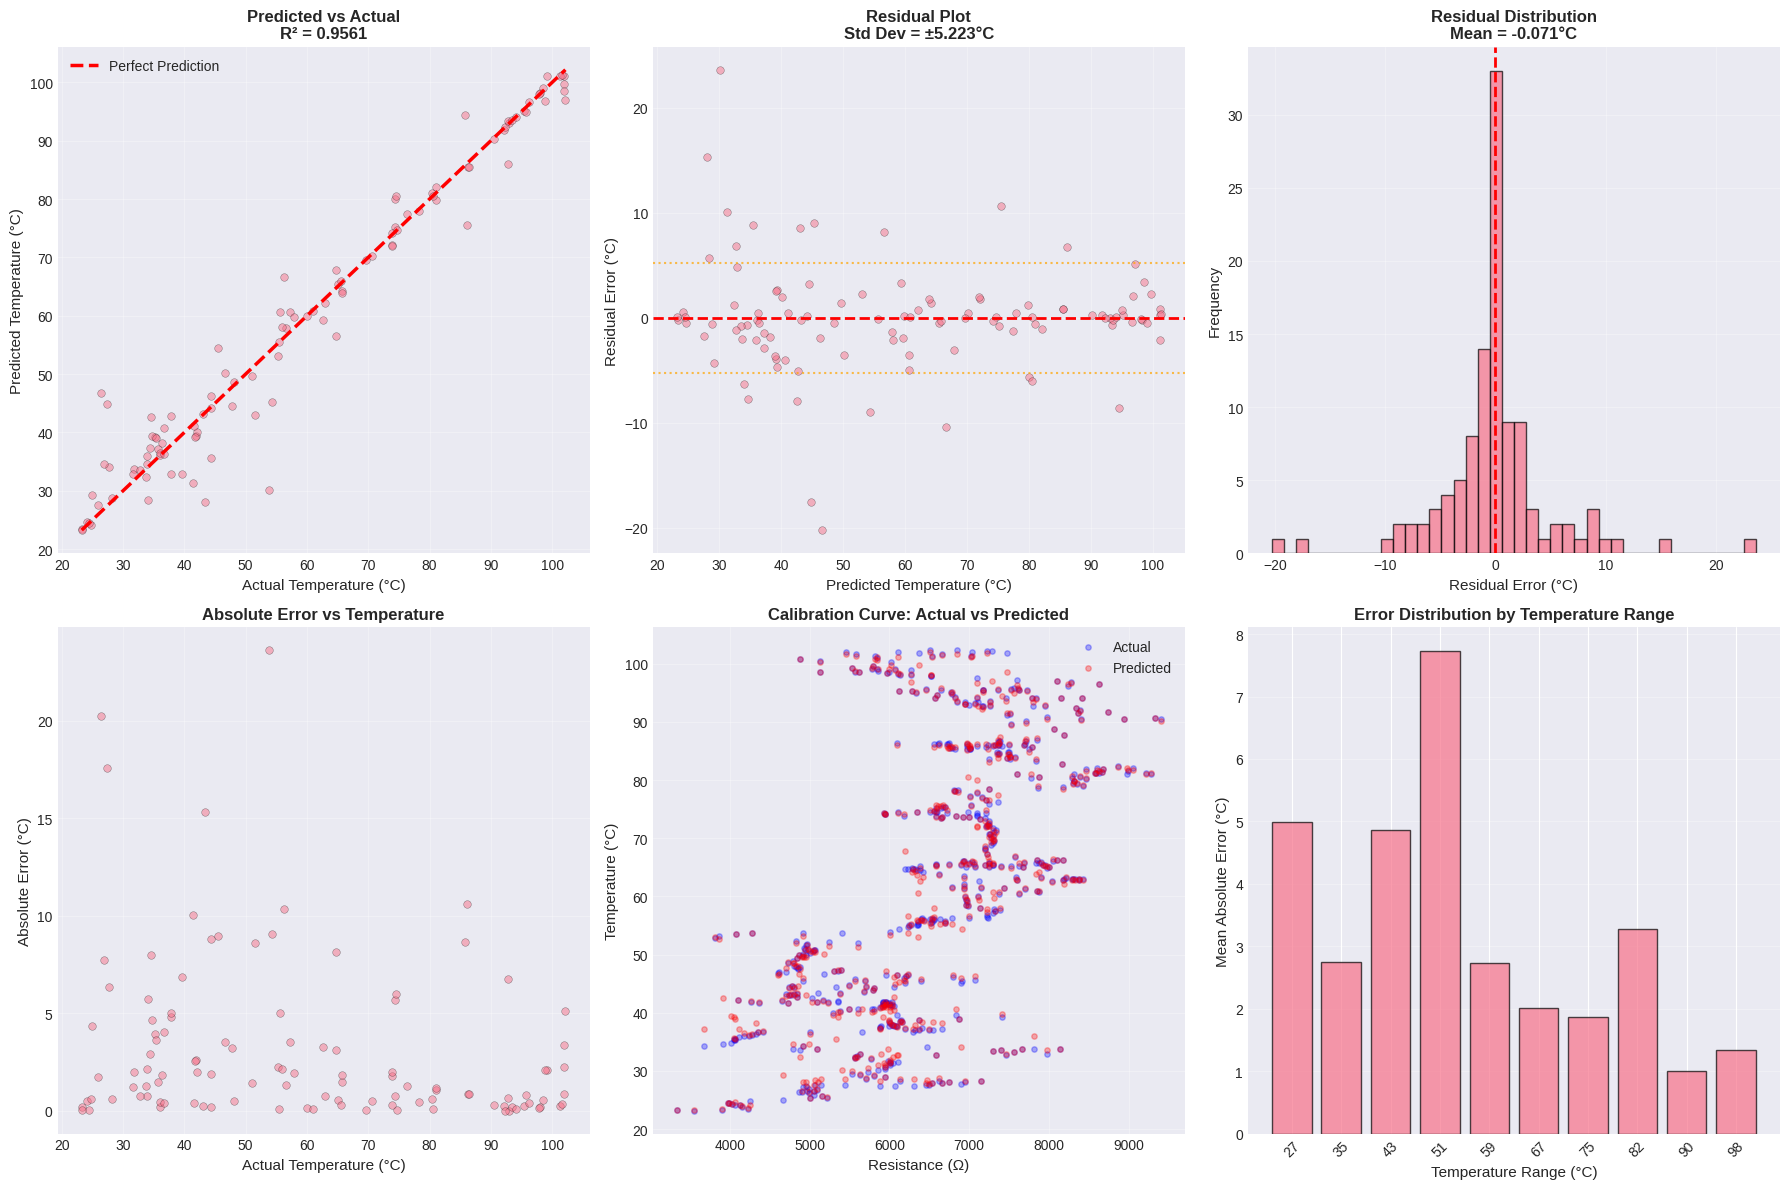

Performance visualization saved: model_performance_full_range.png


In [30]:
# ============================================================================
# CELL 11: Detailed Performance Visualization
# ============================================================================
print("\n[CELL 11] Creating performance visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

X = df_clean[final_features].values
y = df_clean['T'].values
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, random_state=42, shuffle=True
)
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)

# Plot 1: Predicted vs Actual
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.3)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2.5, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Temperature (°C)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Temperature (°C)', fontsize=11)
axes[0, 0].set_title(f'Predicted vs Actual\nR² = {r2_score(y_test, y_test_pred):.4f}',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals vs Predicted
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].axhline(y=residuals.std(), color='orange', linestyle=':', lw=1.5, alpha=0.7)
axes[0, 1].axhline(y=-residuals.std(), color='orange', linestyle=':', lw=1.5, alpha=0.7)
axes[0, 1].set_xlabel('Predicted Temperature (°C)', fontsize=11)
axes[0, 1].set_ylabel('Residual Error (°C)', fontsize=11)
axes[0, 1].set_title(f'Residual Plot\nStd Dev = ±{residuals.std():.3f}°C',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual histogram
axes[0, 2].hist(residuals, bins=40, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Residual Error (°C)', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title(f'Residual Distribution\nMean = {residuals.mean():.3f}°C',
                     fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Error vs Temperature Range
axes[1, 0].scatter(y_test, np.abs(residuals), alpha=0.5, s=30, edgecolors='k', linewidth=0.3)
axes[1, 0].set_xlabel('Actual Temperature (°C)', fontsize=11)
axes[1, 0].set_ylabel('Absolute Error (°C)', fontsize=11)
axes[1, 0].set_title('Absolute Error vs Temperature', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Calibration curve with predictions
axes[1, 1].scatter(df_clean['R'], df_clean['T'], alpha=0.3, s=15, label='Actual', color='blue')
axes[1, 1].scatter(df_clean['R'], df_clean['T_predicted'], alpha=0.3, s=15,
                   label='Predicted', color='red')
axes[1, 1].set_xlabel('Resistance (Ω)', fontsize=11)
axes[1, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[1, 1].set_title('Calibration Curve: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Error distribution across temperature ranges
temp_bins = pd.cut(y_test, bins=10)
error_by_range = pd.DataFrame({'temp_bin': temp_bins, 'abs_error': np.abs(residuals)})
error_summary = error_by_range.groupby('temp_bin')['abs_error'].mean()
bin_centers = [interval.mid for interval in error_summary.index]

axes[1, 2].bar(range(len(bin_centers)), error_summary.values, alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Temperature Range (°C)', fontsize=11)
axes[1, 2].set_ylabel('Mean Absolute Error (°C)', fontsize=11)
axes[1, 2].set_title('Error Distribution by Temperature Range', fontsize=12, fontweight='bold')
axes[1, 2].set_xticks(range(len(bin_centers)))
axes[1, 2].set_xticklabels([f'{c:.0f}' for c in bin_centers], rotation=45)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance_full_range.png', dpi=300, bbox_inches='tight')
plt.show()
print("Performance visualization saved: model_performance_full_range.png")

In [31]:
# ============================================================================
# CELL 12: Test Predictions at Specific Points
# ============================================================================
print("\n[CELL 12] Testing predictions at specific points...")

def predict_temperature(R, T_env, H):
    """Predict temperature using the final calibrated model"""
    feature_dict = {
        'R': R,
        'R_inv': 1.0 / R,
        'ln_R': np.log(R),
        'ln_R_sq': (np.log(R)) ** 2,
        'ln_R_cb': (np.log(R)) ** 3,
        'R_sqrt': np.sqrt(R),
        'R_sq': R ** 2,
        'T_env': T_env,
        'H': H,
        'R_T_env': R * T_env,
        'R_H': R * H,
        'T_env_H': T_env * H,
        'ln_R_T_env': np.log(R) * T_env,
        'ln_R_H': np.log(R) * H
    }
    
    X_input = np.array([[feature_dict[f] for f in final_features]])
    X_scaled = final_scaler.transform(X_input)
    
    return final_model.predict(X_scaled)[0]

test_cases = [
    (4000, 25, 60, "Room temperature"),
    (5533, 22, 63, "Your specific test case (should be ~35°C)"),
    (6000, 23, 62, "Body temperature range"),
    (7500, 23, 61, "Elevated temperature"),
    (10000, 23, 61, "High temperature"),
    (15000, 23, 61, "Very high temperature"),
]

print("\n" + "="*80)
print("PREDICTION TESTS")
print("="*80)

for R, T_env, H, description in test_cases:
    T_pred = predict_temperature(R, T_env, H)
    
    df_close = df_clean[np.abs(df_clean['R'] - R) < 100]
    if len(df_close) > 0:
        actual_avg = df_close['T'].mean()
        print(f"\n{description}:")
        print(f"  R={R}Ω, T_env={T_env}°C, H={H}%")
        print(f"  → Predicted: {T_pred:.2f}°C")
        print(f"  → Actual (nearby): {actual_avg:.2f}°C")
        print(f"  → Difference: {abs(T_pred - actual_avg):.2f}°C")
    else:
        print(f"\n{description}:")
        print(f"  R={R}Ω, T_env={T_env}°C, H={H}%")
        print(f"  → Predicted: {T_pred:.2f}°C")
        print(f"  → (No nearby actual measurements)")


[CELL 12] Testing predictions at specific points...

PREDICTION TESTS

Room temperature:
  R=4000Ω, T_env=25°C, H=60%
  → Predicted: 24.80°C
  → Actual (nearby): 32.89°C
  → Difference: 8.09°C

Your specific test case (should be ~35°C):
  R=5533Ω, T_env=22°C, H=63%
  → Predicted: 27.38°C
  → Actual (nearby): 56.68°C
  → Difference: 29.31°C

Body temperature range:
  R=6000Ω, T_env=23°C, H=62%
  → Predicted: 79.50°C
  → Actual (nearby): 47.35°C
  → Difference: 32.15°C

Elevated temperature:
  R=7500Ω, T_env=23°C, H=61%
  → Predicted: 76.24°C
  → Actual (nearby): 74.65°C
  → Difference: 1.59°C

High temperature:
  R=10000Ω, T_env=23°C, H=61%
  → Predicted: 79.74°C
  → (No nearby actual measurements)

Very high temperature:
  R=15000Ω, T_env=23°C, H=61%
  → Predicted: 79.74°C
  → (No nearby actual measurements)


In [32]:
# ============================================================================
# CELL 13: Save Model and Results
# ============================================================================
print("\n[CELL 13] Saving results...")

df_clean[['T', 'R', 'T_env', 'H', 'T_predicted', 'T_error']].to_csv(
    'sensor_calibration_results.csv', index=False
)
print("Results saved: sensor_calibration_results.csv")

with open('calibration_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("TEMPERATURE SENSOR CALIBRATION SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Data Range:\n")
    f.write(f"  Temperature: {df_clean['T'].min():.2f}°C to {df_clean['T'].max():.2f}°C\n")
    f.write(f"  Resistance: {df_clean['R'].min():.2f}Ω to {df_clean['R'].max():.2f}Ω\n")
    f.write(f"  Samples: {len(df_clean)}\n\n")
    
    f.write(f"Best Model:\n")
    f.write(f"  Type: {best['Model']}\n")
    f.write(f"  Feature Set: {best['FeatureSet']}\n")
    f.write(f"  Features: {final_features}\n\n")
    
    f.write(f"Performance Metrics:\n")
    f.write(f"  Test MAE: {best['Test_MAE']:.3f}°C\n")
    f.write(f"  Test RMSE: {best['Test_RMSE']:.3f}°C\n")
    f.write(f"  Test R²: {best['Test_R2']:.4f}\n")
    f.write(f"  Error Std Dev: {df_clean['T_error'].std():.3f}°C\n\n")
    
    f.write("="*80 + "\n")

print("Summary saved: calibration_summary.txt")

import pickle

model_package = {
    'model': final_model,
    'scaler': final_scaler,
    'features': final_features,
    'model_type': best['Model'],
    'feature_set': best['FeatureSet'],
    'performance': {
        'test_mae': best['Test_MAE'],
        'test_rmse': best['Test_RMSE'],
        'test_r2': best['Test_R2']
    },
    'temp_range': (df_clean['T'].min(), df_clean['T'].max()),
    'resist_range': (df_clean['R'].min(), df_clean['R'].max())
}

with open('temperature_sensor_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved: temperature_sensor_model.pkl")


[CELL 13] Saving results...
Results saved: sensor_calibration_results.csv
Summary saved: calibration_summary.txt
Model saved: temperature_sensor_model.pkl



[CELL 14] Creating standalone prediction function...

Feature Importance:
Feature  Importance
  T_env    0.669436
  R_inv    0.125434
      H    0.080163
ln_R_cb    0.069678
   ln_R    0.055288


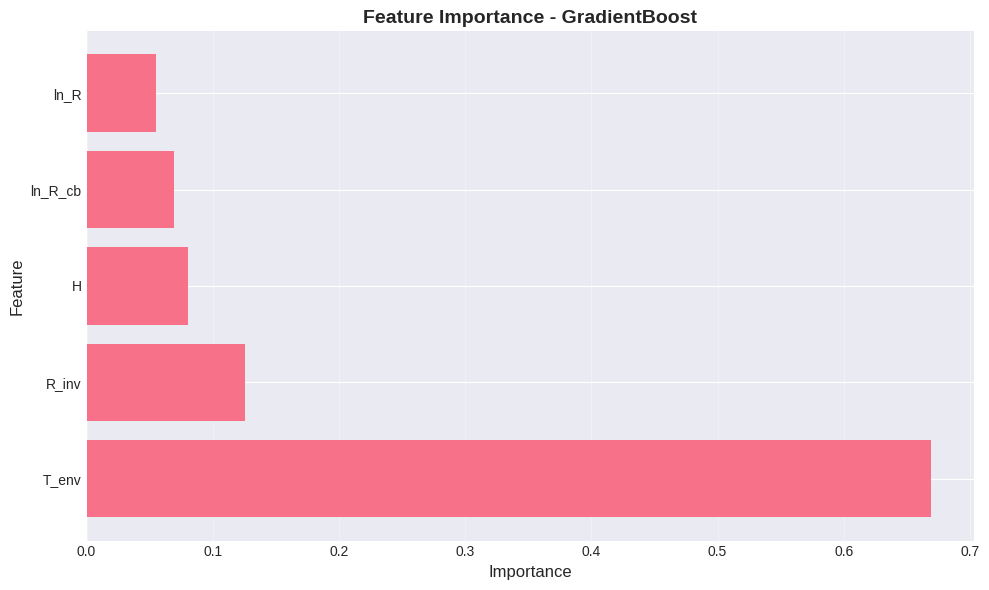

Feature importance saved: feature_importance.png


In [33]:
# ============================================================================
# CELL 14: Create Simple Prediction Function for Export
# ============================================================================
print("\n[CELL 14] Creating standalone prediction function...")

# Extract coefficients if linear model
if best['Model'] in ['LinearReg', 'Ridge']:
    coefficients = final_model.coef_
    intercept = final_model.intercept_
    
    print("\nLinear Model Equation:")
    print(f"T = {intercept:.6f}")
    for i, (feat, coef) in enumerate(zip(final_features, coefficients)):
        print(f"    {coef:+.6f} * {feat}_scaled")
    
    print("\nScaler parameters (for feature scaling):")
    print("Mean:", final_scaler.mean_)
    print("Std:", final_scaler.scale_)

# Feature importance for ensemble models
if best['Model'] in ['RandomForest', 'GradientBoost']:
    importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': final_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance - {best["Model"]}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Feature importance saved: feature_importance.png")


[CELL 15] Detailed error analysis...

ERROR ANALYSIS BY TEMPERATURE RANGE

Room Temperature (20-30°C):
  Samples: 47
  MAE: 1.497°C
  RMSE: 4.249°C
  Max Error: 20.251°C

Body Temperature (30-40°C):
  Samples: 71
  MAE: 1.061°C
  RMSE: 2.039°C
  Max Error: 7.976°C

Elevated (40-60°C):
  Samples: 139
  MAE: 1.180°C
  RMSE: 3.208°C
  Max Error: 23.626°C

High (60-80°C):
  Samples: 133
  MAE: 0.468°C
  RMSE: 1.173°C
  Max Error: 8.161°C

Very High (80-110°C):
  Samples: 158
  MAE: 0.506°C
  RMSE: 1.383°C
  Max Error: 10.619°C


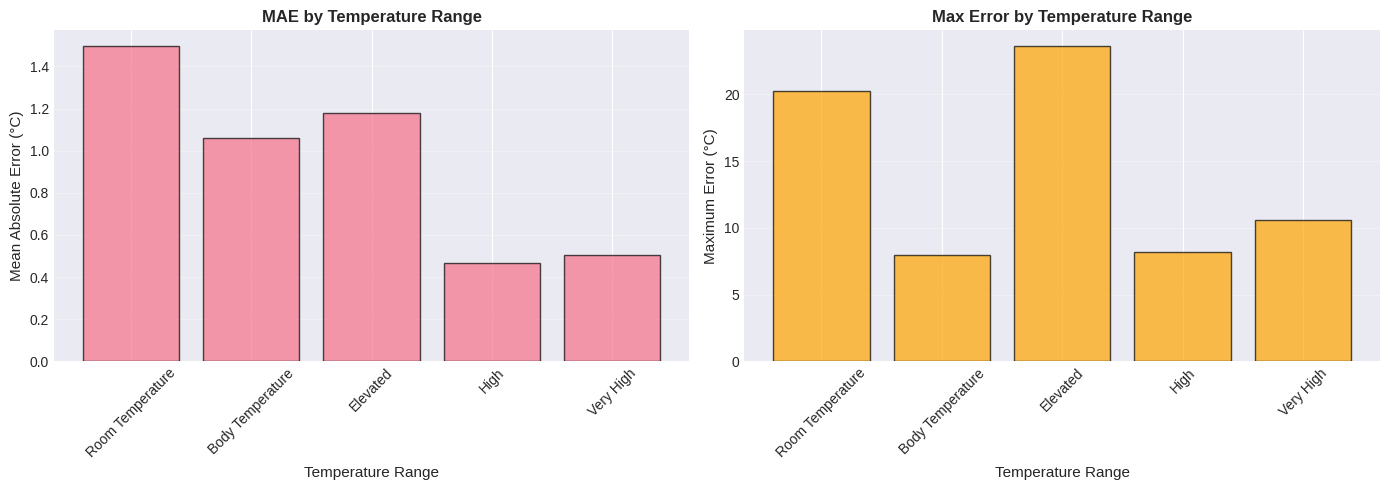


 Error analysis saved: error_by_temperature_range.png


In [34]:
# ============================================================================
# CELL 15: Error Analysis by Temperature Range
# ============================================================================
print("\n[CELL 15] Detailed error analysis...")

# Divide into temperature ranges
temp_ranges = [
    (20, 30, "Room Temperature"),
    (30, 40, "Body Temperature"),
    (40, 60, "Elevated"),
    (60, 80, "High"),
    (80, 110, "Very High")
]

print("\n" + "="*80)
print("ERROR ANALYSIS BY TEMPERATURE RANGE")
print("="*80)

error_analysis = []

for t_min, t_max, label in temp_ranges:
    mask = (df_clean['T'] >= t_min) & (df_clean['T'] < t_max)
    if mask.sum() > 0:
        range_data = df_clean[mask]
        mae = np.abs(range_data['T_error']).mean()
        rmse = np.sqrt((range_data['T_error'] ** 2).mean())
        max_err = np.abs(range_data['T_error']).max()
        n_samples = len(range_data)
        
        print(f"\n{label} ({t_min}-{t_max}°C):")
        print(f"  Samples: {n_samples}")
        print(f"  MAE: {mae:.3f}°C")
        print(f"  RMSE: {rmse:.3f}°C")
        print(f"  Max Error: {max_err:.3f}°C")
        
        error_analysis.append({
            'Range': label,
            'T_min': t_min,
            'T_max': t_max,
            'Samples': n_samples,
            'MAE': mae,
            'RMSE': rmse,
            'Max_Error': max_err
        })

error_df = pd.DataFrame(error_analysis)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(error_df['Range'], error_df['MAE'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Mean Absolute Error (°C)', fontsize=11)
axes[0].set_xlabel('Temperature Range', fontsize=11)
axes[0].set_title('MAE by Temperature Range', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(error_df['Range'], error_df['Max_Error'], alpha=0.7, 
            edgecolor='black', color='orange')
axes[1].set_ylabel('Maximum Error (°C)', fontsize=11)
axes[1].set_xlabel('Temperature Range', fontsize=11)
axes[1].set_title('Max Error by Temperature Range', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('error_by_temperature_range.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Error analysis saved: error_by_temperature_range.png")

In [35]:
# ============================================================================
# CELL 16: Final Report
# ============================================================================
print("\n" + "="*80)
print("CALIBRATION COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n Dataset Statistics:")
print(f"   • Total samples: {len(df_clean)}")
print(f"   • Temperature range: {df_clean['T'].min():.1f}°C to {df_clean['T'].max():.1f}°C")
print(f"   • Resistance range: {df_clean['R'].min():.0f}Ω to {df_clean['R'].max():.0f}Ω")

print(f"\n Best Model: {best['Model']}")
print(f"   • Feature set: {best['FeatureSet']}")
print(f"   • Number of features: {len(final_features)}")

print(f"\n Performance Metrics:")
print(f"   • Test MAE: {best['Test_MAE']:.3f}°C")
print(f"   • Test RMSE: {best['Test_RMSE']:.3f}°C")
print(f"   • Test R²: {best['Test_R2']:.4f}")
print(f"   • Error Std Dev: {df_clean['T_error'].std():.3f}°C")

print(f"\n Accuracy Assessment:")
if best['Test_MAE'] < 0.5:
    print("   ✓ EXCELLENT - Clinical grade accuracy")
elif best['Test_MAE'] < 1.0:
    print("   ✓ VERY GOOD - Suitable for body temperature monitoring")
elif best['Test_MAE'] < 2.0:
    print("   ✓ GOOD - Acceptable for general temperature sensing")
else:
    print("   ⚠ MODERATE - May need further calibration")

print(f"\n Saved Files:")
print("   • full_range_data_analysis.png - Data visualization")
print("   • correlation_matrix_full_range.png - Feature correlations")
print("   • model_performance_full_range.png - Model performance")
print("   • error_by_temperature_range.png - Error analysis")
print("   • sensor_calibration_results.csv - Detailed results")
print("   • calibration_summary.txt - Summary report")
print("   • temperature_sensor_model.pkl - Trained model")
if best['Model'] in ['RandomForest', 'GradientBoost']:
    print("   • feature_importance.png - Feature importance")

print(f"\n Next Steps:")
print("   1. Review the visualizations to understand model performance")
print("   2. Check error analysis by temperature range")
print("   3. Use the prediction function to test specific R values")
print("   4. Load the saved model for deployment:")
print("      import pickle")
print("      with open('temperature_sensor_model.pkl', 'rb') as f:")
print("          model_pkg = pickle.load(f)")


CALIBRATION COMPLETE - FINAL SUMMARY

 Dataset Statistics:
   • Total samples: 548
   • Temperature range: 23.2°C to 102.3°C
   • Resistance range: 3339Ω to 9398Ω

 Best Model: GradientBoost
   • Feature set: Steinhart_Hart
   • Number of features: 5

 Performance Metrics:
   • Test MAE: 3.093°C
   • Test RMSE: 5.224°C
   • Test R²: 0.9561
   • Error Std Dev: 2.365°C

 Accuracy Assessment:
   ⚠ MODERATE - May need further calibration

 Saved Files:
   • full_range_data_analysis.png - Data visualization
   • correlation_matrix_full_range.png - Feature correlations
   • model_performance_full_range.png - Model performance
   • error_by_temperature_range.png - Error analysis
   • sensor_calibration_results.csv - Detailed results
   • calibration_summary.txt - Summary report
   • temperature_sensor_model.pkl - Trained model
   • feature_importance.png - Feature importance

 Next Steps:
   1. Review the visualizations to understand model performance
   2. Check error analysis by temperatur